# Lab 7
This is the jupyter notebook for lab 7. First we will import some libraries and functions. 

In [1]:
from numpy import genfromtxt
import numpy as np
from netCDF4 import MFDataset 
from netCDF4 import Dataset 
import matplotlib
matplotlib.use('Agg')
import matplotlib.pylab as plt
from mpl_toolkits.basemap import Basemap
from datetime import datetime
from netCDF4 import num2date
from netCDF4 import date2index
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
from metpy.units import units
import xarray as xr
import cartopy.util as cutil
%matplotlib inline

Our next setep is to read in the netCDF files. 

In [2]:
ds = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/air.mon.mean.nc')
ds2 = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/hgt.mon.mean.nc')
ds3 = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/uwnd.mon.mean.nc')
ds4 = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/vwnd.mon.mean.nc')


Provide the pressure level and month you wish to plot. Also provide the month as a string, so our caption is attractive. 

In [3]:
plevel = 500
month = 1
monthlabel = 'January'
tm = int(month)-1

Now we extract the data desired. 

In [4]:
# Grab lat/lon values
lats = ds.lat.data
lons = ds.lon.data

#subtract 1 from tm because the first observation in Python is observation 0

temp = ds.air.sel(level=plevel)[tm::12,:,:].values
hght = ds2.hgt.sel(level=plevel)[tm::12,:,:].values
uwnd = ds3.uwnd.sel(level=plevel).values[:][tm::12,:,:] * units('m/s')
vwnd = ds4.vwnd.sel(level=plevel).values[:][tm::12,:,:] * units('m/s')



Print the numpy shapes of the temperature, latitude and longtitude. This can be important when debugging.

In [5]:
print (np.shape(temp))
print (np.shape(lats))
print (np.shape(lons))

(73, 73, 144)
(73,)
(144,)


Now we need to read in the index data (in this case, the nao). We read in from a text file, which has the year and monthly values in columns

In [6]:
infile = open('nao.txt', 'r')
nao = infile.readlines()
print (np.shape(nao))

for i in range(len(nao)):
  nao[i] = nao[i].split()

nao = np.array(nao).astype('float')
print (np.shape(nao))


(69,)
(69, 13)


Now we calculate the correlation field between the index and the 500 hPa Z. The first step is to make objects with the right dimensions, before we can copy the correlation values. Note that the data is subset to leave off the first two years, for which the NAO data is not available. (The final year is left off too, since it is NA for some of the months.) 

In [7]:
hgtcor=np.zeros((hght.shape[1],hght.shape[2]))
tempcor=np.zeros((temp.shape[1],temp.shape[2]))

for i in range(hght.shape[1]):
    for j in range(hght.shape[2]):
       hgtcor[i,j] = np.corrcoef(hght[2:69,i,j], nao[2:69,month])[1,0]
       tempcor[i,j] = np.corrcoef(temp[2:69,i,j], nao[2:69,month])[1,0]


Select the countour settings for the correlation The format is (minimum, maximum, interval) 

In [8]:
clevs_cor = np.arange(-1,1.1,0.1)

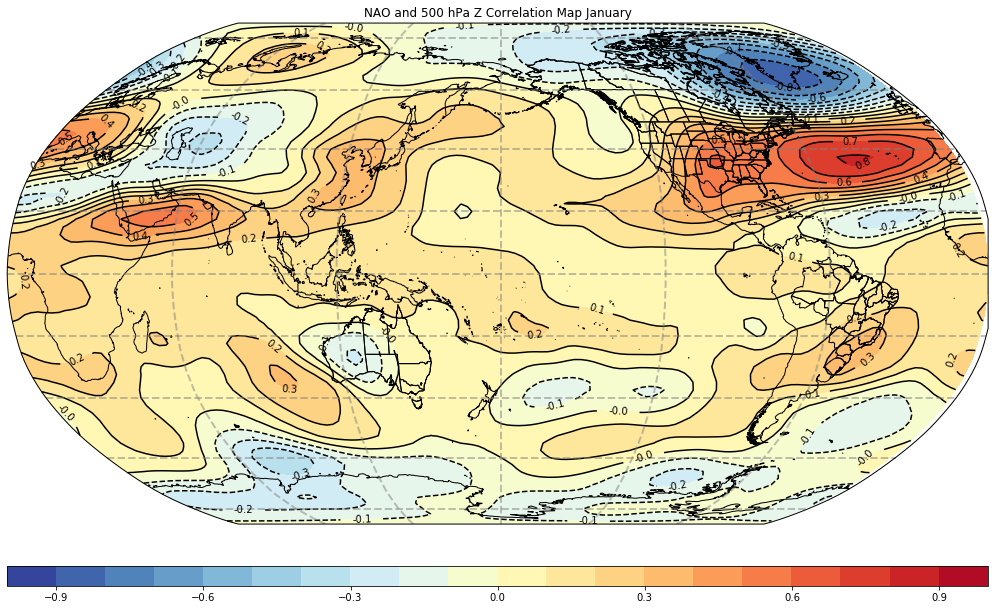

In [9]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.Robinson(central_longitude=180)

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)

#not needed here, but used for sub-setting domain to plot
#ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))
gl = ax.gridlines(color='gray',linewidth=2, alpha = 0.5, linestyle='--')

# labels gridlines for PlateCarree ccrs option (doesn't work with Robinson, etc.)
#gl.xlabels_top = False
#gl.ylabels_right = False

#color-filled contour time!
#plotting temperature and including color bar
cf = ax.contourf(lons, lats, hgtcor, clevs_cor, cmap=plt.cm.RdYlBu_r, transform=datacrs)

plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)

# Plot 500-hPa Geopotential Height Anomaly in meters
#cs = ax.contour(lons, lats, hght[ty,:,:] - np.mean(hght[:,:,:],axis=0), clevs_hght_anom, colors='black', transform=datacrs)
#plt.clabel(cs, fmt='%d')

# Plot 500-hPa Geopotential Heights in meters
cs = ax.contour(lons, lats, hgtcor, clevs_cor, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%1.1f')

# Plot 500-hPa wind barbs in knots, regrid to reduce number of barbs
#ax.barbs(lons[::4], lats[::4], uwnd.to('kt')[ty,::4,::4].m, 
#         vwnd.to('kt')[ty,::4,::4].m, pivot='middle',
#         color='black', transform=datacrs, length=5, linewidth=0.4)

# Make some nice titles for the plot (one right, one left)
plt.title('NAO and 500 hPa Z Correlation Map ' + str(monthlabel))

# Reduce excessive white space around image and show
plt.tight_layout()
plt.savefig('NAOand500hPaZcorrelationmap' + str(monthlabel), dpi=150)
plt.show()

We can plot the time series and histogram of the NAO

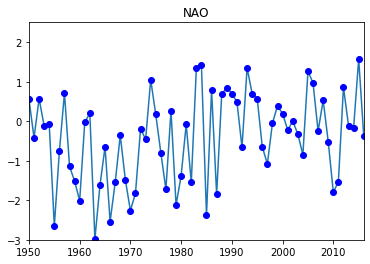

In [10]:
plt.plot(nao[2:69,0],nao[2:69,1])
plt.plot(nao[2:69,0],nao[2:69,1], 'bo')
plt.axis([1950, 2016, -3, 2.5])
plt.title('NAO')
plt.show()

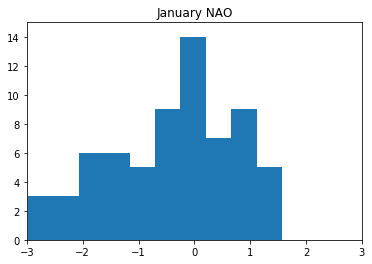

In [11]:
plt.hist(nao[2:69,1])
plt.title(str(monthlabel) + ' NAO')
plt.axis([-3, 3, 0, 15])
plt.show()

Now, we will read in your index data and see how it relates to the NAO! 

In [12]:
sourcefile = open('index.csv','rb')
indexdata = genfromtxt(sourcefile,delimiter=',')
print(np.shape(indexdata))

(67, 2)


Make a scatterplot of the NAO and your leading pattern index

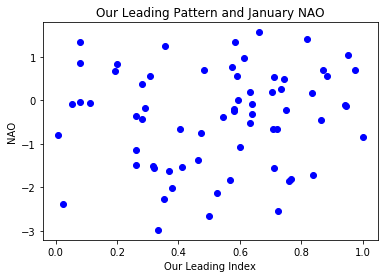

In [13]:
plt.plot(indexdata[0:67,1],nao[2:69,1], 'bo')
#plt.axis([-2, 2, -2, 2])
plt.title('Our Leading Pattern and January NAO')
plt.xlabel('Our Leading Index')
plt.ylabel('NAO')
plt.show()

Correlation:

In [14]:
print(np.corrcoef(indexdata[0:67,1],nao[2:69,1])[1,0])

0.12002163887804915


Standard deviation:

In [15]:
print(np.std(indexdata[0:67,1]))

0.2616556663005023


In [16]:
print(np.std(nao[2:69,1]))

1.1225945943667301
